# Project 3 - Completely Fair Scheduler Analysis
### CS337 Operating Systems Prof. Al Madi - Spring 2022
###### Matthew Bass : 03/02/2022
---
## Abstract:

   This is a Jupyter Notebook to analyze the Completely Fair Scheduling
   Algorithm which is kind of like ideal fairness scheduling. Ideal fairness
   scheduling is where CPU time is divided up among all processes evenly. CFS
    is a slightly different take on this where it aims to where each process
    have a virtual runtime associated with it that increases monotonically.
    To Implement this algorithm I first will construct a fully functioning
    Red Black Tree then run simulations with the algorithm to see how it
    preforms with CPU vs I/O bound tasks and analyze and compare their
    general stats along with other scheduling algorithms.

---

## Setup:

In [17]:
# Importing necessary libraries import copy
import pandas as pd
import operating_system
import scheduler
from RBTree import RBTree
from process import Process
import copy
import sys

sys.setrecursionlimit(10000)

<br>

---
## Testing Red Black Tree

To start I am going to test my Red Black Tree data structure with 10 nodes
with values 1-10

In [18]:
# Make the test tree
test_tree = RBTree()

for num in range(10):
    test_tree.insert(key=num+1)

# Display the test tree
test_tree.display_tree()

From the graph we can see the RB tree is working with insertion (with unique
key values) as expected with the results of this tree being confirmed by [RB
Tree Visualizer](https://www.cs.usfca.edu/~galles/visualization/RedBlack.html)


Now I am going to test removing the min_vruntime which should show that 1 is
removed


In [19]:
test_tree.remove_min_vruntime()
test_tree.display_tree()

From here we can see that it worked for the first min_vruntime by confirming
it with being confirmed by [RB
Tree Visualizer](https://www.cs.usfca.edu/~galles/visualization/RedBlack.html)

Now we will try it again for the next min_vruntime which should be 2

In [20]:
test_tree.remove_min_vruntime()
test_tree.display_tree()

Again we can see that it works now I will try deleting a node other than the
min_vruntime (I will delete node 9)

In [21]:
test_tree.delete(9)
test_tree.display_tree()

Again we can see that the deletion works

Now I am going to try inserting replicate keys

In [22]:
test_tree.insert(7)
test_tree.insert(6)
test_tree.insert(3)
test_tree.display_tree()

After confirming that has worked I am going to try removing the min_vruntime
again now that there are duplicates of it (just testing a delete case)

In [23]:
test_tree.remove_min_vruntime()
test_tree.display_tree()

#### Testing other RB Tree Edge cases.

##### Multiple nodes with the same value (vruntime)

Now I am going to test what happens when there are multiple nodes with the
same key values.

In [24]:
test_tree2 = RBTree()

test_tree2_vals = [1,2,3,4] * 5
for val in test_tree2_vals:
    test_tree2.insert(val)

# test_tree2.display_tree()

test_tree2.print_tree()

ROOT
R----3(BLACK)
     L----2(BLACK)
     |    L----1(RED)
     |    |    L----1(BLACK)
     |    |    |    L----1(RED)
     |    |    |    R----1(RED)
     |    |    R----1(RED)
     |    R----2(RED)
     |         L----2(RED)
     |         R----2(BLACK)
     |              R----2(RED)
     R----4(BLACK)
          L----3(RED)
          |    L----3(RED)
          |    R----3(BLACK)
          |         R----3(RED)
          R----4(RED)
               L----4(RED)
               R----4(BLACK)
                    R----4(RED)




#### Testing Tree with Process functions

When running simulations with a lot of processes I found that if there were 3
 or more processes with teh same vruntime then the RBtree would break because
  it would not know how to search for other nodes (would be the same value as
  the left and right child and the parent node). So I implemented a fix if
  their data was a list of processes and created the function `insert_process
  ()` for the RBtree and also modified how `min_vruntime()` worked when the data
  of the node was a list of processes

In [25]:
# Make the test tree 2
test_tree3 = RBTree()

#making tesst processes
test_tree3_procs = [Process(1,[3,1,3],4,5), Process(2,[3,1,3],4,5),
                    Process(3,[3,1,3],4,5), Process(4,[3,1,3],4,5),
                    Process(5,[3,1,3],4,5), Process(6,[3,1,3],4,5),
                    Process(7,[3,1,3],4,5), Process(8,[3,1,3],4,5)]

test_tree3_procs[0].vruntime = 25
test_tree3_procs[1].vruntime = 10
test_tree3_procs[2].vruntime = 2
test_tree3_procs[3].vruntime = 25
test_tree3_procs[4].vruntime = 30
test_tree3_procs[5].vruntime = 25
test_tree3_procs[6].vruntime = 2
test_tree3_procs[7].vruntime = 1

#insert all the processes
for proc in test_tree3_procs:
    test_tree3.insert_process(proc)

test_tree3.display_tree()
# test_tree3.print_tree()

Now I will remove the min vruntime which should be 1

In [26]:
test_tree3.remove_min_vruntime()
test_tree3.display_tree()

From here we can see that it worked for the first min_vruntime by confirming
it with being confirmed by [RB
Tree Visualizer](https://www.cs.usfca.edu/~galles/visualization/RedBlack.html)

Again I will remove the min vruntime but now the tree should look the same
because there are multiple processes with the same vruntime.

In [27]:
test_tree3.remove_min_vruntime()
test_tree3.display_tree()

As you can see the tree does remain the same for to change we will have to \
        remove the min vruntime a couple more times

In [28]:
test_tree3.remove_min_vruntime()
test_tree3.remove_min_vruntime()
test_tree3.display_tree()

As we can see `remove_vruntime()` is working as expected.

<br>

---
## Completely Fair Scheduling (CFS):

The Completely Fair Scheduling algorithm is a process scheduling that has
been used by the linux scheduler since 2.6.23 (2007) as the default scheduler
  , the `SCHED_NORMAL` class in linux. It has no heuristics and aims for
  elegant handling of I/O and CPU bound processes. It does this by scheduling
  processes based on their updating virtual runtime choosing the
  process to run with the minimum virtual runtime. (The amount of time for a
  given task on a processor is computed dynamically as the scheduling context
   changes over the system's lifetime. )

Virtual runtime is calculated by:

$ vruntime = t * weight$ where t is the time spent in the CPU, and weight
  is the priority value between 1 [high priority] and 10 [low priority] )

The process
with the minimum vruntime is selected to run for a dynamic quantum
calculated using the following equation:

$dynamic$ $quantum = target$ $latency /$ #$ready$ $processes$

Target latency defines the maximum response time for a process in the
        system. This dynamic quantum guarantees fairness. If dynamic quantum
        is less than 1, then a value of 1 is chosen, and fairness is ignored
        as the system runs more processes than it can handle.

Also instead of a normal ready queue to hold all the processes CFS uses a Red
 Black Tree to hold all the processes that are ready to be scheduled.  The
 data structure is well-suited for the job because it is a self-balancing binary
 search tree, with efficient insert and remove operations that execute in O(log N) time,
  where N is the number of nodes in the tree. Also, a tree is an excellent data structure for
  organizing entities into a hierarchy based on a particular property, in
  this case a vruntime. Processes with the lowest vruntime (the
  greatest need for a processor) reside somewhere in the left subtree. Processes
  with relatively high vruntimes congregate in the right subtree. A preempted task would go into the right subtree, thus
  giving other tasks a chance to move leftwards in the tree. A task with the
  minimum vruntime winds up in the tree's leftmost node.


The main goal of the CFS is that I/O bound processes should get higher priority
and get a longer time to execute compared to CPU bound.
CFS achieves this efficiently:
 - I/O bound processes have small CPU bursts therefore will have a low vruntime.
 - They would appear towards the left of the tree, thus are given higher
 priorities.
 - I/O bound processes will typically have larger time slices because they have
 smaller vruntime.
    
    
#### Testing:

In [29]:
# Run the kernel with CFS and base test processes
operating_system.kernal(scheduler.CFS_scheduler,
           file_proc_name="test")

In [30]:
# Importing the results from CFS test
cfs_results_all = pd.read_csv(
    "data/Combined_Data/All_CFS_test_results.csv")

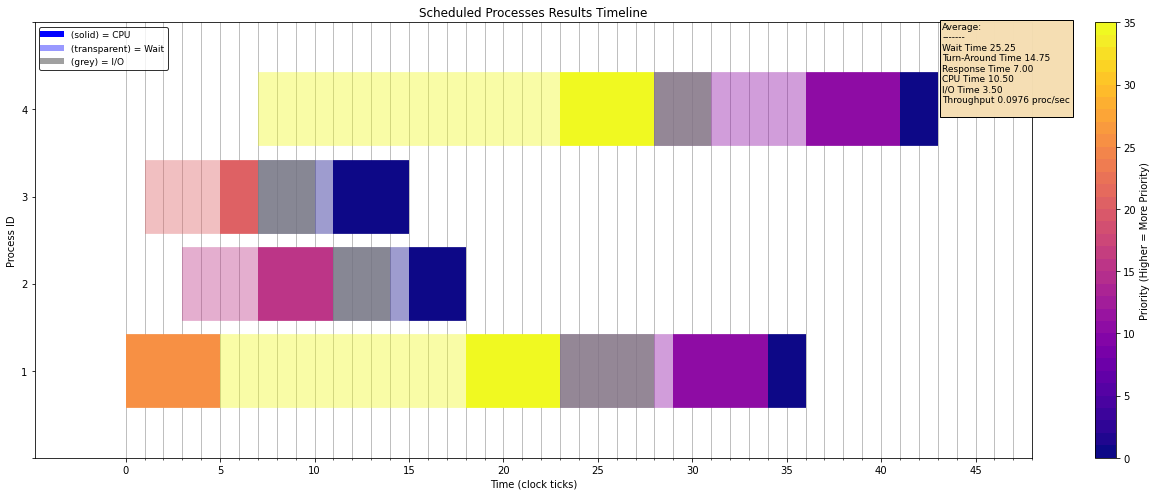

In [31]:
# Plotting the Results Enhanced
operating_system.plotKernalResults(cfs_results_all,
                      "Completely Fair Scheduling Test Results Timeline")


Here we can see that completely fair scheduling does occur based on the
vruntime of the process (In the plot priority level is matching the vruntime)


<br>

---
## Simulation of CFS

Here I will run simulations with a 50/50 split of CPU and I/O bound processes
to compare the general statistics such as the average turnaround time,
response time, wait time and throughput between CPU and I/0 bound processes with
 CFS

In [32]:
cfs_sim_procs = operating_system.generate_processes(n = 1000, seed=10)


# Run the kernel with CFS and processes
operating_system.kernal(scheduler.CFS_scheduler, processes=cfs_sim_procs,
                            file_proc_name="sim1", debug=False)

# Importing the CPU results from CFS
cfs_sim_results_1 = pd.read_csv("data/Combined_Data/" +
                                    "All_CFS_sim1_results.csv")

# printing the results
operating_system.printKernalResultStats(cfs_sim_results_1, title = "Completely "
                                                                "Fair "
                                                                "Scheduling "
                                                                "Sim")

# printing the results based on type
operating_system.printKernalResultStatsProcTypes(cfs_sim_results_1,
                                                     title="Completely "
                                                                   "Fair "
                                                                   "Scheduling "
                                                                   "Sim")

KeyError: 'attival time'

#### Simulation observations:

From running CFS with an about 50/50 split of CPU and I/O bound processes it
is clear that this algorithm does indeed favor I/O bound processes as they
have a much lower average wait, turnaround, and response times of 22.23 , 18
.16, and 5.38 seconds respectively; when compared to CPU bound processes with
 average wait, turnaround, and response times of 1592.29 , 1572.26, and 820.53
 seconds respectively. They do however have close throughput values at 0.0415
  proc/sec for CPU bound processes and 0.0497
  proc/sec for I/O bound processes.

**QUESTION**
This shows that CPU and I/O bound
  processes are tried to be scheduled in a way that gives them similar
  throughput but favors I/O bound tasks since they don't need to use the CPU
  as much making the os using this scheduler seems much more interactive
  because I/O bound tasks hae better response and turn around times


<br>

---
## Simulations with other Algorithms (Extension):

Now I will run simulations with a 50/50 split of CPU and I/O bound processes
to compare the general statistics such as the average
turnaround time,
response time, wait time, and throughput of the following scheduling
algorithms with CFS:

    - Round Robin with quantum of 10
    - Shortest Remaining Time
    - Multilevel Feedback Queue (RR2 => RR 10 => FCFS)





Below I Compare all the simulations to

##### Setting up Process:

In [ ]:
sim_procs1 = operating_system.generate_processes(n = 1000,seed=1)
sim_procs2 = copy.deepcopy(sim_procs1)
sim_procs3 = copy.deepcopy(sim_procs1)
sim_procs4 = copy.deepcopy(sim_procs1)


#### Completely Fair Scheduling:

In [ ]:
# Run the kernel with CFS and processes
operating_system.kernal(scheduler.CFS_scheduler, processes=sim_procs1,
                            file_proc_name="sim", debug=False)

# Importing the CPU results from CFS
cfs_sim_results = pd.read_csv("data/Combined_Data/" +
                                    "All_CFS_sim_results.csv")

# printing the results
operating_system.printKernalResultStats(cfs_sim_results, title = "Completely "
                                                                "Fair "
                                                                "Scheduling "
                                                                "Sim")

# printing the results based on type
operating_system.printKernalResultStatsProcTypes(cfs_sim_results,
                                                     title="Completely "
                                                                   "Fair "
                                                                   "Scheduling "
                                                                   "Sim")


#### Round Robin with quantum of 10:

In [ ]:
# Run the kernel with RR10 and processes
operating_system.kernal(scheduler.RR_scheduler,quantum=10, processes=sim_procs2,
                            file_proc_name="sim", debug=False)

# Importing the CPU results from RR10
rr_q10_sim_results = pd.read_csv("data/Combined_Data/" +
                                    "All_RR_Q10_sim_results.csv")

# printing the results
operating_system.printKernalResultStats(rr_q10_sim_results, title = "Round Robin Q10 Sim")
operating_system.printKernalResultStatsProcTypes(rr_q10_sim_results, title = "Round "
                                                                     "Robin Q10 Sim")


##### CFS vs RR 10 Comparison:

When looking at a round-robin of 10 I see that it does not favor either I/O
nor CPU bound processes. CPU bound processes on average have wait, turnaround,
and response times of 1819.24, 1799.23, and 274.38 seconds respectively and I/O
 bound processes have an
 average wait, turnaround, and response times of 1133.58 , 1129.51, and 302.98
 seconds respectively. This is very different from CFS which as we have shown
  before , and can see in the other simulation of it above, favors I/O bound
  processes.

It makes sense that RR would not favor a processes based on if it is CPU or
I/O bound because the whole idea of how RR works is that all processes in the
 ready queue are run for an equal amount of time determined by the quantum
 (in this case the quantum is 10) and if processes in the ready queue have
 been run for the same number of times then the process chosen is the one
 that arrived the earliest. All together this makes RR indiscriminate of the
  process type when scheduling processes.

**QUESTION**
Its throughput also differs with RR10. In RR10, CPU bound
  processes have a throughput of 0.0448 procs/sec and I/O bound
  processes have  a throughput of 0.0413 procs/sec. In CFS, CPU bound
  processes have a throughput of 0.0509 procs/sec and I/O bound
  processes have  a throughput of 0.0413 procs/sec.

So as we can see CFS
  results in a bit more throughput when it comes to CPU bound processes and
  the same throughput when it comes to CPU bound processes (most likely due to
   rounding)

<br>

#### Shortest Remaining Time:

In [ ]:
# Run the kernel with SRT and processes
operating_system.kernal(scheduler.SRT_scheduler, processes=sim_procs3,
                            file_proc_name="sim", debug=False)

# Importing the CPU results from SRT
srt_sim_results = pd.read_csv("data/Combined_Data/" +
                                    "All_SRT_sim_results.csv")

# printing the results
operating_system.printKernalResultStats(srt_sim_results, title = "SRT Sim")
operating_system.printKernalResultStatsProcTypes(srt_sim_results, title = "SRT Sim")


##### CFS vs SRT Comparison:

When looking at Shortest Remaining Time I see that it does favor I/O
bound processes with I/O bound processes on average having wait, turnaround,
and response times of 15.64, 11.57, and 1.61 seconds respectively and CPU
bound processes have an
 average wait, turnaround, and response times of 1270.87 , 1250.87, and 302.98
 seconds respectively. Also, I/O bound processes have a throughput of 0.0510
 proc/sec and I/O bound processes have a throughput of 0.0414 proc/sec.

It makes sense that SRT found favor I/O bound processes because by their
definition they have shorter CPU burst times than CPU bound processes. This
means they will always have priority over.

When comparing it to CFS it is very similar in the fact that it favors I/O
bound processes however because in CFS the process is run based off the
dynamic quantum and not preempted until it is over CFS does not favor I/O
bound processes as much since it will not instantly preempt the CPU bound
process to run the I/O bound one if the process arrives to the ready queue
like SRT will. This can be sen because for CFS, I/O processes on average have
 a wait time of 22.35, turn-around time of 18.28, response time of 5.37 and a
  throughput of 0.0509 proc/sec.

<br>



#### Multilevel Feedback Queue (RR2 => RR 10 => FCFS):

In [ ]:
# Run the kernel with MLFQ and processes
operating_system.kernal(scheduler.MLFQ_scheduler, processes=sim_procs4,
                        quantum= 2, quantum2= 10,
                            file_proc_name="2_10_sim", debug=False)

# Importing the CPU results from MLFQ
mlfq_sim_results = pd.read_csv("data/Combined_Data/" +
                                    "All_MLFQ_2_10_sim_results.csv")

# printing the results
operating_system.printKernalResultStats(mlfq_sim_results, title = "MLFQ_2_10 Sim")
operating_system.printKernalResultStatsProcTypes(mlfq_sim_results, title = "MLFQ_2_10"
                                                                   " Sim")


##### CFS vs MLFQ Comparison:

When looking at MLFQ I see that it does not favor I/O
bound processes nor CPU bound ones.I/O bound processes on average having
wait,
turnaround,
and response times of 945.56, 941.49, and 4.72 seconds respectively and CPU
bound processes have an
 average wait, turnaround, and response times of 3800.27 , 3780.26, and 4.42
 seconds respectively. Also, I/O bound processes have a throughput of 0.0510
 proc/sec and I/O bound processes have a throughput of 0.0414 proc/sec.



When comparing it to CFS it is clear that MLFQ is worse in general, with
general statistics for al processes being much greater that CFS. The only
advantage MLFQ appears to have over CFS is that is gives an average low
response time for all processes which makes sense because its first level is
a RR with a quantum of 2 resulting in lots of fast context switching to
process that have arrived in the ready queue, while CFS just prioritized I/O
bound processes.

<br>

---

## References and Acknowledgements

On this project I received help and knowledge from :
   - [Dr. Al Madi](https://www.cs.colby.edu/nsalmadi/)
   - [Dr. Al Madi CFS notes](https://github.com/mattjax16/CS337-Operating-Systems/blob/d31fb7d1c8a561d1e64eca13df35b7739d4e7265/Notes/6-%20Completely%20Fair%20Scheduler.pdf)
   - [Project Details](https://github.com/mattjax16/CS337-Operating-Systems/blob/master/Projects/Proj2/Project%202_%20Preemptive%20CPU%20Scheduling.pdf)
   - [Wiki on RB Trees](https://en.wikipedia.org/wiki/Red%E2%80%93black_tree)
   - [Wiki on CFS](https://en.wikipedia.org/wiki/Completely_Fair_Scheduler)
   - [Linux Journal](https://www.linuxjournal.com/node/10267)
   - [Matplotlib event plot documentation](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.eventplot.html)
   - [General Matplotlib Docs](https://matplotlib.org/)




